In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import ipywidgets as widgets

%matplotlib widget
%load_ext autoreload
%autoreload 2


1.0 0.08203369379043579


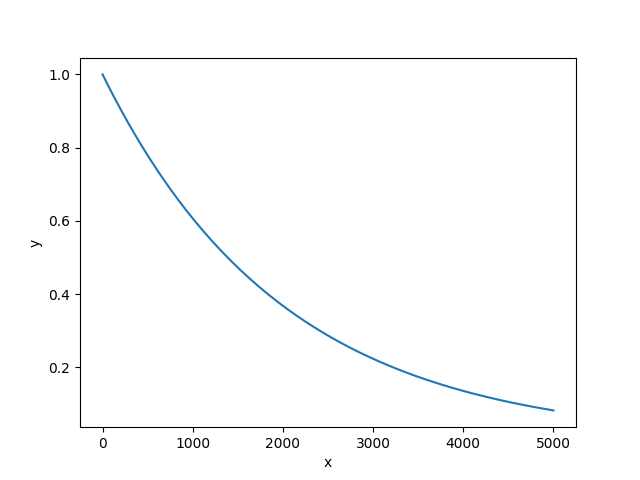

In [2]:
linspace = np.linspace(0, 5000, 50)
x = torch.tensor(linspace, requires_grad=False)
y = (1 * 0.9995 ** x).float()

fig, ax = plt.subplots()
ax.plot(linspace, y.numpy())
ax.set_xlabel('x')
ax.set_ylabel('y')
print(y[0].item(), y[-1].item())


In [3]:
# batch, player, position(x, y)
team = torch.tensor([[[1, 2], [3, 4]], [[7, 8], [9, 10]]]).float()
target = (1, 2)
target_torch = torch.tensor(target).repeat(team.shape[0], 1).unsqueeze(1).float()
print(team.shape, target_torch.shape)

norm = torch.norm(team - target_torch, dim=2)
print(norm)

torch.Size([2, 2, 2]) torch.Size([2, 1, 2])
tensor([[ 0.0000,  2.8284],
        [ 8.4853, 11.3137]])


In [4]:
torch.mean(norm, dim=1)

tensor([1.4142, 9.8995])

In [5]:
scaling = (norm)
foo = scaling * norm
foo_sum = foo.sum(dim=1).unsqueeze(1)
print(foo_sum)
print(norm)
print(norm*foo_sum)

tensor([[  8.0000],
        [200.0000]])
tensor([[ 0.0000,  2.8284],
        [ 8.4853, 11.3137]])
tensor([[   0.0000,   22.6274],
        [1697.0560, 2262.7415]])


In [6]:
num_frequencies = 5

freq_bands = torch.linspace(1.0, 2 ** (num_frequencies - 1), num_frequencies)
print(freq_bands)

tensor([ 1.0000,  4.7500,  8.5000, 12.2500, 16.0000])


In [7]:
nums = torch.linspace(-0.5, 0.5, 1000)

for i in range(num_frequencies):
    plt.plot(nums, torch.sin(nums * freq_bands[i]).numpy())


In [8]:
from train import train
field_hight = 9000
field_width = 7000
model = train(players_per_team=1, 
        epochs=20000, 
        field_hight=field_hight, 
        field_width=field_width, 
        load_model=False,
)

Epoch [0/20000], Loss: -0.00585
Epoch [50/20000], Loss: -0.02975
Epoch [100/20000], Loss: -0.07188
Epoch [150/20000], Loss: -0.08633
Epoch [200/20000], Loss: -0.13293
Epoch [250/20000], Loss: -0.13126


15

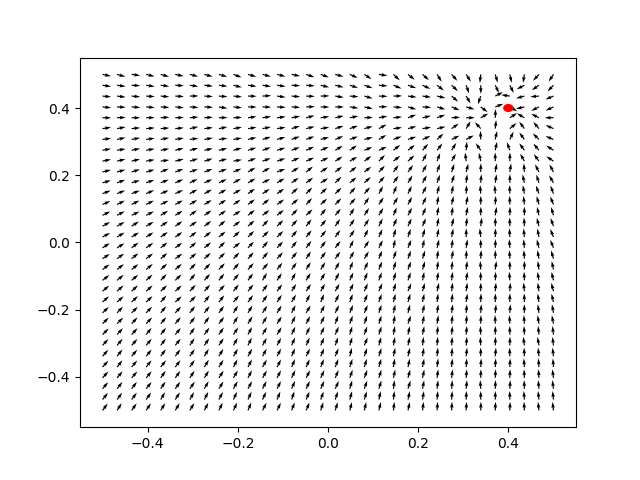

37.233604
21.893223
14.83861
33.655373
12.832052
17.469433
16.35178
9.165549


In [ ]:
samples = 32
x, y = torch.meshgrid(torch.linspace(-0.5, 0.5, samples), torch.linspace(-0.5, 0.5, samples))
x = x.flatten()
y = y.flatten()
scale = torch.tensor([field_width, field_hight]).float()

team = torch.stack([x, y], dim=1).unsqueeze(1) * scale
enemy = torch.stack([y, x], dim=1).unsqueeze(1) * scale

ball = torch.tensor([0.4, 0.4]).float().repeat(team.shape[0], 1).unsqueeze(1) * scale

delta = model(team, enemy, ball).squeeze(1).detach().numpy()
# norm_delta = delta / torch.norm(delta, dim=1).unsqueeze(1)


fig, ax = plt.subplots()
# when a click is detected of fig, the mouse position is sent to the model
def on_mose_click(event):
    global delta
    x = event.xdata
    y = event.ydata
    # print(x, y)
    ball = torch.tensor([x, y]).float().repeat(team.shape[0], 1).unsqueeze(1) * scale
    old_delta = delta.copy()
    delta = model(team, enemy, ball).squeeze(1).detach().numpy()
    print(np.linalg.norm(delta - old_delta))
    ax.clear()
    
    ax.quiver(team[:, 0, 0]/scale[0], team[:, 0, 1]/scale[1], delta[:, 0], delta[:, 1])
    circle = plt.Circle((x, y), 0.01, color='r')
    ax.add_artist(circle)
    fig.canvas.draw()


ax.quiver(team[:, 0, 0]/scale[0], team[:, 0, 1]/scale[1], delta[:, 0], delta[:, 1])
circal = plt.Circle(ball[0, 0]/scale, 0.01, color='r')
ax.add_artist(circal)
fig.canvas.mpl_connect('button_press_event', on_mose_click)


